# Importing Packages and Data

In [43]:
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Mute warnings.
import warnings
warnings.filterwarnings('ignore')



In [44]:
path = r"C:\Users\alger\Documents\000. Projects\002. CAM DS\Course 1\6.3.1 Customer Segmentation\Instacart data\orders.csv"
df = pd.read_csv(path)

df = df.drop(columns=["order_dow","eval_set","order_number","order_hour_of_day"])

In [45]:
df["order_value"] = np.random.randint(1, 151, size=len(df))
df["days_since_prior_order"] = df["days_since_prior_order"].fillna(0)

unique_users = df["user_id"].unique()
random_ages = np.random.randint(18, 76, size=len(unique_users))
user_ages = dict(zip(unique_users, random_ages))

customer_frequency = df.groupby("user_id")["user_id"].count()
customer_lifetime_value = df.groupby("user_id")["order_value"].sum()
avg_unit_cost = df.groupby("user_id")["order_value"].mean()

df["Customer Age"] = df["user_id"].map(user_ages)
df["Customer Frequency"] = df["user_id"].map(customer_frequency)
df["Customer Lifetime Value"] = df["user_id"].map(customer_lifetime_value)
df["Avg Unit Cost"] = df["user_id"].map(avg_unit_cost)

df

,order_id,user_id,days_since_prior_order,order_value,Customer Age,Customer Frequency,Customer Lifetime Value,Avg Unit Cost
0,2539329,1,0.0,125,59,11,881,80.090909
1,2398795,1,15.0,145,59,11,881,80.090909
2,473747,1,21.0,1,59,11,881,80.090909
3,2254736,1,29.0,42,59,11,881,80.090909
4,431534,1,28.0,59,59,11,881,80.090909
...,...,...,...,...,...,...,...,...
3421078,2266710,206209,29.0,77,46,14,1106,79.000000
3421079,1854736,206209,30.0,87,46,14,1106,79.000000
3421080,626363,206209,18.0,5,46,14,1106,79.000000
3421081,2977660,206209,7.0,133,46,14,1106,79.000000


In [46]:
# Define the date range (as pandas Timestamps)
start_date = pd.to_datetime("2010-01-01")
end_date   = pd.to_datetime("2020-01-01")

# Compute the number of days between start_date and end_date
days_diff = (end_date - start_date).days  # This should be an integer

# For safety, ensure 'days_since_prior_order' is integer
df["days_since_prior_order"] = df["days_since_prior_order"].astype(int)

# Create empty 'order_date'
df["order_date"] = pd.NaT

# Get unique users
unique_users = df["user_id"].unique()

# Generate random offsets in days within the range [0, days_diff]
random_offsets = np.random.randint(0, days_diff, size=len(unique_users))

# Create a dictionary mapping each user to a random start date
# by adding the offset to the start_date
user_start_dates = {
    user: (start_date + pd.Timedelta(days=offset))
    for user, offset in zip(unique_users, random_offsets)
}

# Assign the initial order_date (where days_since_prior_order == 0)
df.loc[df["days_since_prior_order"] == 0, "order_date"] = (
    df["user_id"].map(user_start_dates)
)

# Forward-fill the 'order_date' and add the 'days_since_prior_order'
df["order_date"] = (
    df.groupby("user_id")["order_date"].ffill()
    + pd.to_timedelta(df["days_since_prior_order"], unit="D")
)

# Convert to datetime
df["order_date"] = pd.to_datetime(df["order_date"])

df

,order_id,user_id,days_since_prior_order,order_value,Customer Age,Customer Frequency,Customer Lifetime Value,Avg Unit Cost,order_date
0,2539329,1,0,125,59,11,881,80.090909,2011-01-10
1,2398795,1,15,145,59,11,881,80.090909,2011-01-25
2,473747,1,21,1,59,11,881,80.090909,2011-01-31
3,2254736,1,29,42,59,11,881,80.090909,2011-02-08
4,431534,1,28,59,59,11,881,80.090909,2011-02-07
...,...,...,...,...,...,...,...,...,...
3421078,2266710,206209,29,77,46,14,1106,79.000000,2010-02-14
3421079,1854736,206209,30,87,46,14,1106,79.000000,2010-02-15
3421080,626363,206209,18,5,46,14,1106,79.000000,2010-02-03
3421081,2977660,206209,7,133,46,14,1106,79.000000,2010-01-23


In [47]:
today_date = pd.to_datetime("today")

# 1. Get the most recent order_date per user
most_recent_order = df.groupby("user_id")["order_date"].max()

# 2. Calculate Recency as the difference between today's date and the most recent order
recency = (today_date - most_recent_order).dt.days

# 3. Map the calculated recency back to the original dataframe
df["Recency"] = df["user_id"].map(recency)

df

,order_id,user_id,days_since_prior_order,order_value,Customer Age,Customer Frequency,Customer Lifetime Value,Avg Unit Cost,order_date,Recency
0,2539329,1,0,125,59,11,881,80.090909,2011-01-10,5112
1,2398795,1,15,145,59,11,881,80.090909,2011-01-25,5112
2,473747,1,21,1,59,11,881,80.090909,2011-01-31,5112
3,2254736,1,29,42,59,11,881,80.090909,2011-02-08,5112
4,431534,1,28,59,59,11,881,80.090909,2011-02-07,5112
...,...,...,...,...,...,...,...,...,...,...
3421078,2266710,206209,29,77,46,14,1106,79.000000,2010-02-14,5471
3421079,1854736,206209,30,87,46,14,1106,79.000000,2010-02-15,5471
3421080,626363,206209,18,5,46,14,1106,79.000000,2010-02-03,5471
3421081,2977660,206209,7,133,46,14,1106,79.000000,2010-01-23,5471


# Data Transformation and Selection

Now the data is clean and new features have been made which combine several other features, we will drop features we no longer need and keep only those we are interested in. Then we will transform the data to have one customer per row, and encoding the necessary features.

Note that while Continent and Loyalty Num are encoded, they are not included in

In [48]:
# Using agg function to aggregate by Customer ID
df_customer = df.groupby('user_id').agg({
    'Customer Frequency': 'mean',             # Average of Customer Frequency
    'Recency': 'min',                        # Average of Recency
    'Customer Lifetime Value': 'mean',        # Average of Customer Lifetime Value
    'Avg Unit Cost': 'mean',                  # Average of Avg Unit Cost
    'Customer Age': 'mean'                    # Average of Customer Age
}).reset_index()

df_customer = df_customer.rename(columns={"user_id": "Customer ID"})

df_customer = df_customer.sample(frac=0.5, random_state=42).reset_index(drop=True)

df_customer

,Customer ID,Customer Frequency,Recency,Customer Lifetime Value,Avg Unit Cost,Customer Age
0,189033,9.0,4467,665.0,73.888889,55.0
1,113007,4.0,4769,268.0,67.000000,21.0
2,40369,17.0,4939,1202.0,70.705882,58.0
3,2153,18.0,5135,1258.0,69.888889,61.0
4,194850,65.0,2913,4865.0,74.846154,46.0
...,...,...,...,...,...,...
103099,8022,42.0,2360,3116.0,74.190476,50.0
103100,61230,21.0,3474,1543.0,73.476190,67.0
103101,155850,41.0,3531,2877.0,70.170732,39.0
103102,82356,100.0,2647,7313.0,73.130000,59.0


# Data Exploration

In [49]:
# Summary Statistics
df_customer.describe().round(2)

,Customer ID,Customer Frequency,Recency,Customer Lifetime Value,Avg Unit Cost,Customer Age
count,103104.00,103104.00,103104.00,103104.00,103104.00,103104.00
mean,103421.56,16.59,3664.75,1251.91,75.41,46.45
std,59551.41,16.67,1051.37,1273.09,14.48,16.74
min,1.00,4.00,1835.00,24.00,6.00,18.00
25%,51801.75,6.00,2758.00,451.00,67.04,32.00
50%,103586.50,10.00,3665.00,784.00,75.43,46.00
75%,155312.75,20.00,4573.00,1536.00,83.78,61.00
max,206208.00,100.00,5508.00,8896.00,145.50,75.00


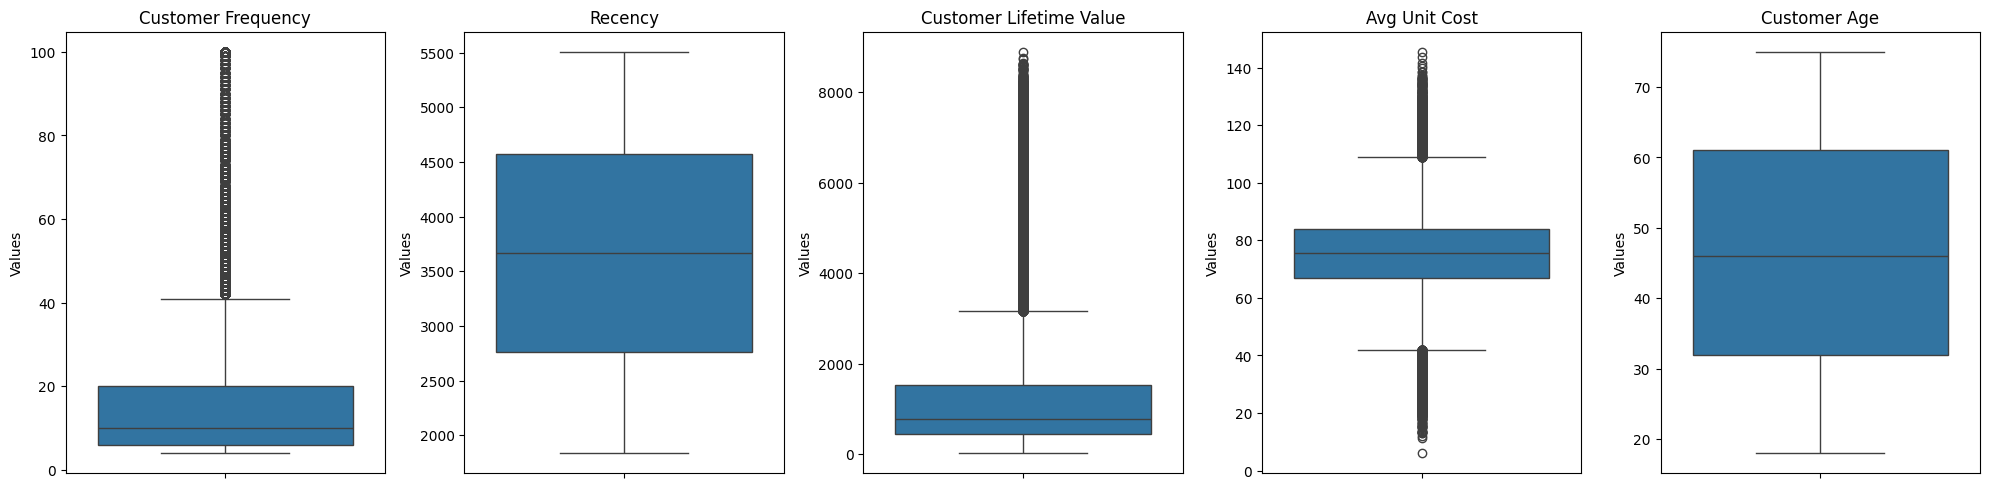

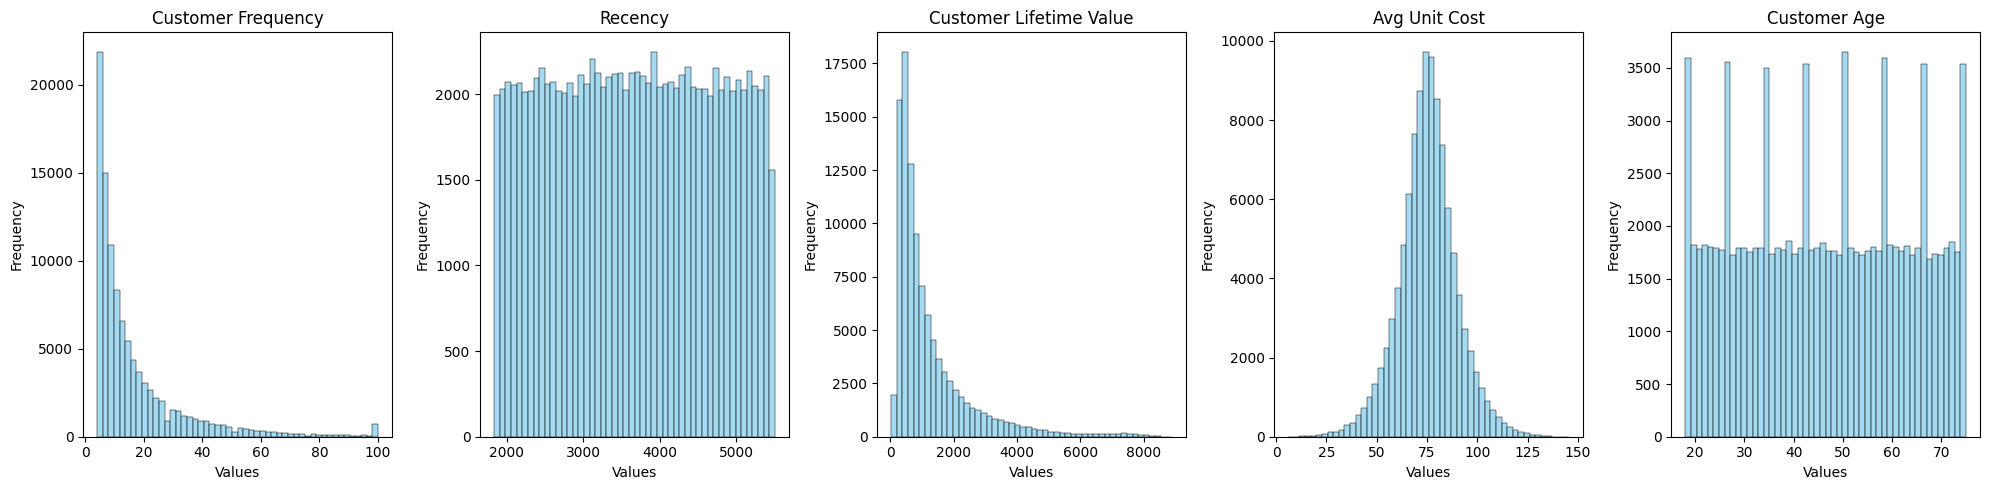

In [50]:
# Visualising data using boxplots for each feature
# Exclude 'Customer ID' column
features_to_visualize = df_customer.drop(columns=['Customer ID'])

# Visualising summary statistics using boxplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns), figsize=(20, 5))

# Loop through each column and create a boxplot
for i, col in enumerate(features_to_visualize.columns):
    sns.boxplot(y=features_to_visualize[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

print()

# Visualising distributions of each feature using a histogram
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns), figsize=(20, 5))

# Loop through each column to create a histogram using seaborn
for i, col in enumerate(features_to_visualize.columns):
    sns.histplot(features_to_visualize[col], bins=50, kde=False, color='skyblue', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

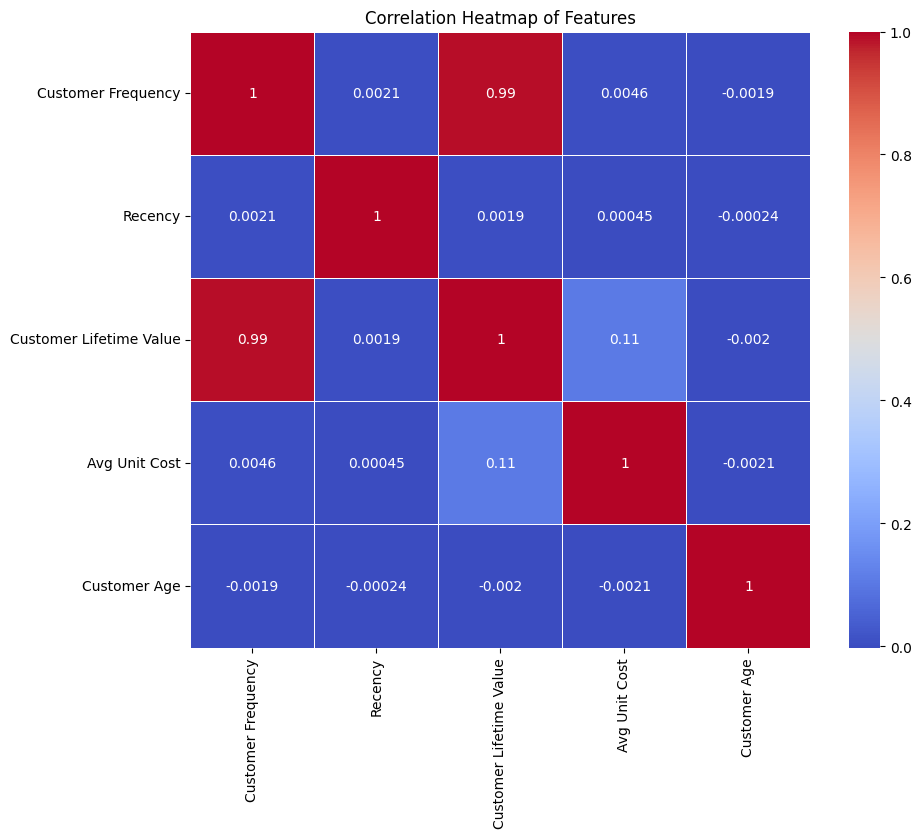

In [51]:
# Calculate the correlation matrix
correlation_matrix = features_to_visualize.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

As can be observed in the box plots, there are outliers in most features. They will not be removed as the underlying dataset should naturally contain outliers (e.g. Unit Price where for example a few customers may only be interested in specialised, expensive products)

# Clustering with K-Means

The data will be segmented using K-Means clustering, starting with four clusters  

In [52]:
# Preprocessing data
features_to_cluster = df_customer[['Customer Frequency', 'Recency', 'Customer Lifetime Value', 'Avg Unit Cost', 'Customer Age']]

# Standardize the data using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_to_cluster.columns)
    ]
)

features_scaled = preprocessor.fit_transform(features_to_cluster)

In [53]:
# Perform K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the DataFrame
df_customer['Cluster'] = cluster_labels

# Print the number of observations in each cluster
cluster_counts = df_customer['Cluster'].value_counts().sort_index()
print("\nNumber of observations in each cluster:")
print(cluster_counts)

# Display the aggregated DataFrame
df_customer.round(2)


Number of observations in each cluster:
Cluster
0    23972
1    34164
2    33235
3    11733
Name: count, dtype: int64


,Customer ID,Customer Frequency,Recency,Customer Lifetime Value,Avg Unit Cost,Customer Age,Cluster
0,189033,9.0,4467,665.0,73.89,55.0,2
1,113007,4.0,4769,268.0,67.00,21.0,1
2,40369,17.0,4939,1202.0,70.71,58.0,2
3,2153,18.0,5135,1258.0,69.89,61.0,2
4,194850,65.0,2913,4865.0,74.85,46.0,3
...,...,...,...,...,...,...,...
103099,8022,42.0,2360,3116.0,74.19,50.0,3
103100,61230,21.0,3474,1543.0,73.48,67.0,2
103101,155850,41.0,3531,2877.0,70.17,39.0,3
103102,82356,100.0,2647,7313.0,73.13,59.0,3


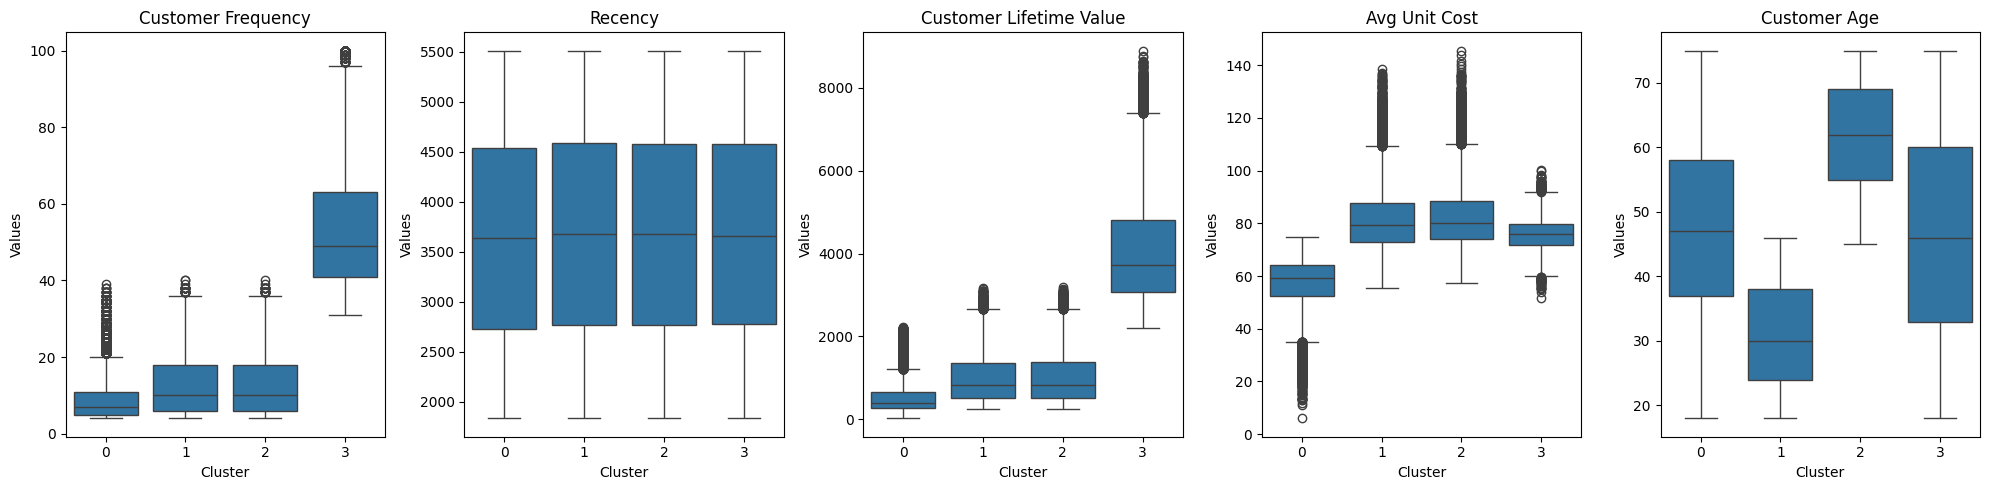

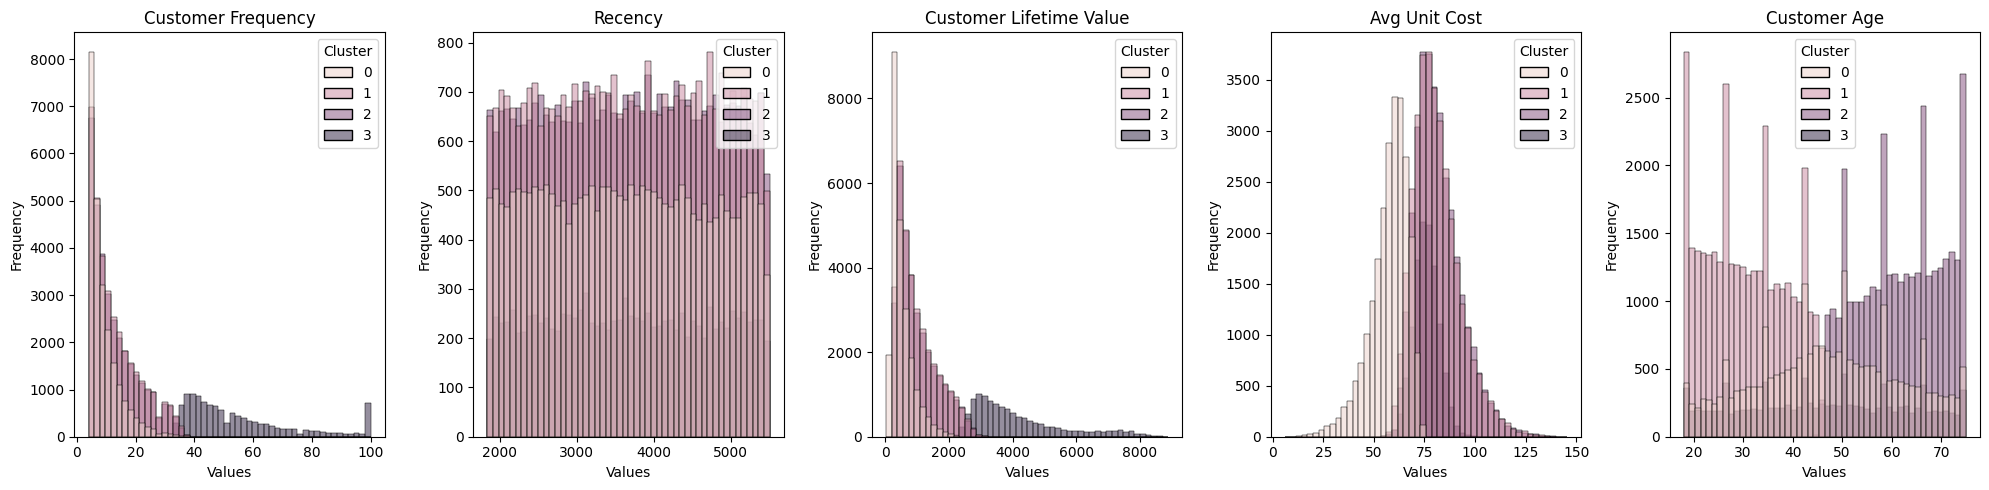

In [54]:
# Visualising data using boxplots and Histograms for each feature
# Exclude 'Customer ID' and 'Cluster' columns
features_to_visualize = df_customer.drop(columns=['Customer ID'])

# Visualising summary statistics using boxplots for each feature by cluster
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns) - 1, figsize=(20, 5))

# Loop through each column and create a boxplot
for i, col in enumerate(features_to_visualize.columns[:-1]):
    sns.boxplot(x='Cluster', y=col, data=features_to_visualize, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

# Visualising distributions of each feature using histograms by cluster
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns) - 1, figsize=(20, 5))

# Loop through each column to create a histogram using seaborn
for i, col in enumerate(features_to_visualize.columns[:-1]):
    sns.histplot(data=features_to_visualize, x=col, hue='Cluster', bins=50, kde=False, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

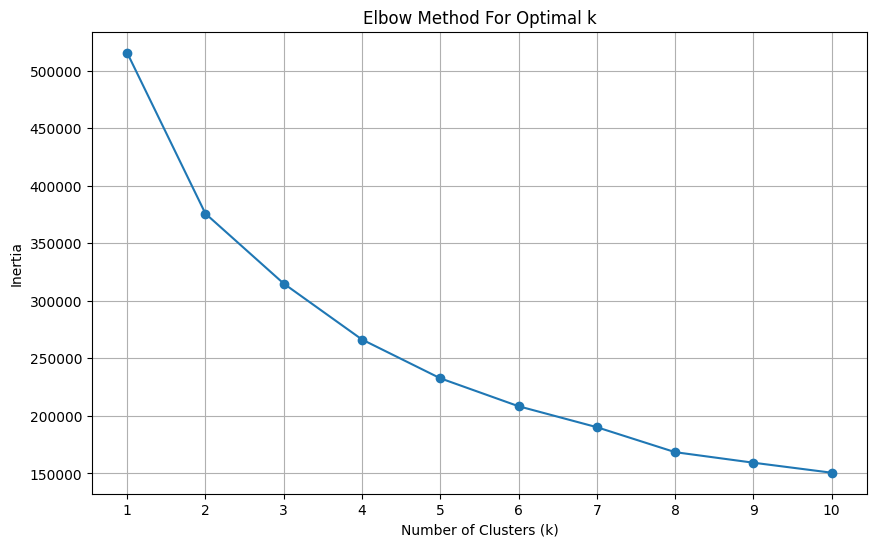

In [55]:
# Elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The k which presents diminishing returns to adding more clusters is closer to three than four, indicating that the initial model ran with four clusters is slightly higher than the Elbow method suggests is appropriate. To confirm these findings, the silhouette method will be used to compare a three and four cluster model.

In [56]:
# Function to run a k-means model and plot the silhouette scores
def plot_silhouette(features, n_clusters):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(features)

    silhouette_avg = silhouette_score(features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title(f"The silhouette plot for the various clusters with n_clusters = {n_clusters}")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

For n_clusters = 4, the average silhouette_score is: 0.20678271095874032


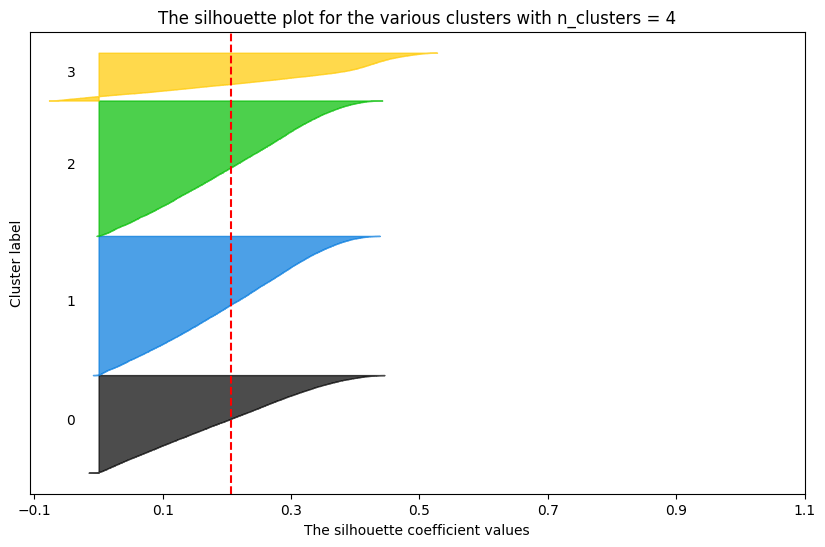

For n_clusters = 3, the average silhouette_score is: 0.19210578654166915


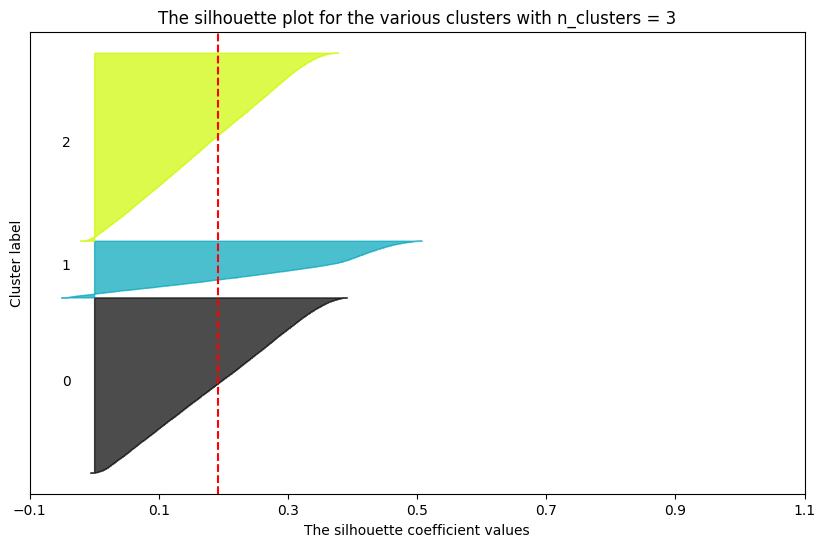

In [57]:
# Run silhouette analysis for n_clusters = 4
plot_silhouette(features_scaled, n_clusters=4)

# Run silhouette analysis for n_clusters = 3
plot_silhouette(features_scaled, n_clusters=3)

The average silhouette scores are low and do not change much between the three and four cluster models, indicating that there isn't much difference in the 'fitness' of either model, therefore based on the Elbow method and Silhouette scores the optimum $k$ can either be three or four. We will now use agglomerative hierarchical clustering, which generates the number of clusters itself and shows sub-clusters. This method of clustering will be ran on half the dataset to limit computational power use.

In [58]:
# Randomly sample half of the data
df_sample = df_customer.sample(frac=0.5, random_state=42)

# Select columns for hierarchical clustering
features_for_clustering = df_sample[['Customer Frequency', 'Recency', 'Customer Lifetime Value', 'Avg Unit Cost', 'Customer Age']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

In [59]:
# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
agg_clustering.fit(features_scaled)

# Generate the linkage matrix
linked = linkage(features_scaled, method='ward')

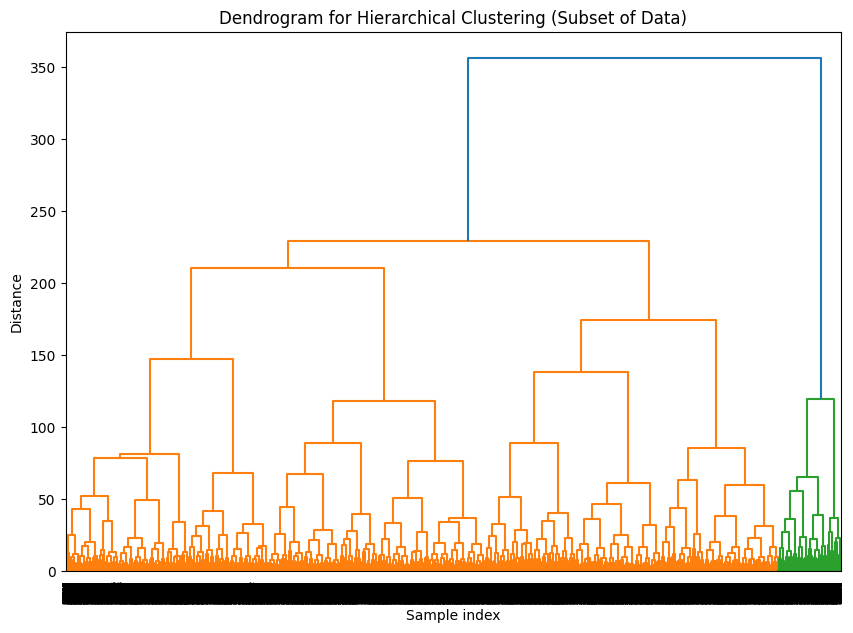

In [60]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering (Subset of Data)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In line with the elbow method, agglomerative clustering indicates that three clusters is appropriate for this dataset, noting that one is much smaller than the others. Going forward this figure for $k$ will be used.

In [61]:
# Preprocessing data
features_to_cluster = df_customer[['Customer Frequency', 'Recency', 'Customer Lifetime Value', 'Avg Unit Cost', 'Customer Age']]

# Standardize the data using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_to_cluster.columns)
    ]
)

features_scaled = preprocessor.fit_transform(features_to_cluster)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the DataFrame
df_customer['Cluster'] = cluster_labels

# Print the number of observations in each cluster
cluster_counts = df_customer['Cluster'].value_counts().sort_index()
print("\nNumber of observations in each cluster:")
print(cluster_counts)

# Display the aggregated DataFrame
df_customer.round(2)


Number of observations in each cluster:
Cluster
0    43044
1    13905
2    46155
Name: count, dtype: int64


,Customer ID,Customer Frequency,Recency,Customer Lifetime Value,Avg Unit Cost,Customer Age,Cluster
0,189033,9.0,4467,665.0,73.89,55.0,0
1,113007,4.0,4769,268.0,67.00,21.0,0
2,40369,17.0,4939,1202.0,70.71,58.0,0
3,2153,18.0,5135,1258.0,69.89,61.0,0
4,194850,65.0,2913,4865.0,74.85,46.0,1
...,...,...,...,...,...,...,...
103099,8022,42.0,2360,3116.0,74.19,50.0,1
103100,61230,21.0,3474,1543.0,73.48,67.0,2
103101,155850,41.0,3531,2877.0,70.17,39.0,1
103102,82356,100.0,2647,7313.0,73.13,59.0,1


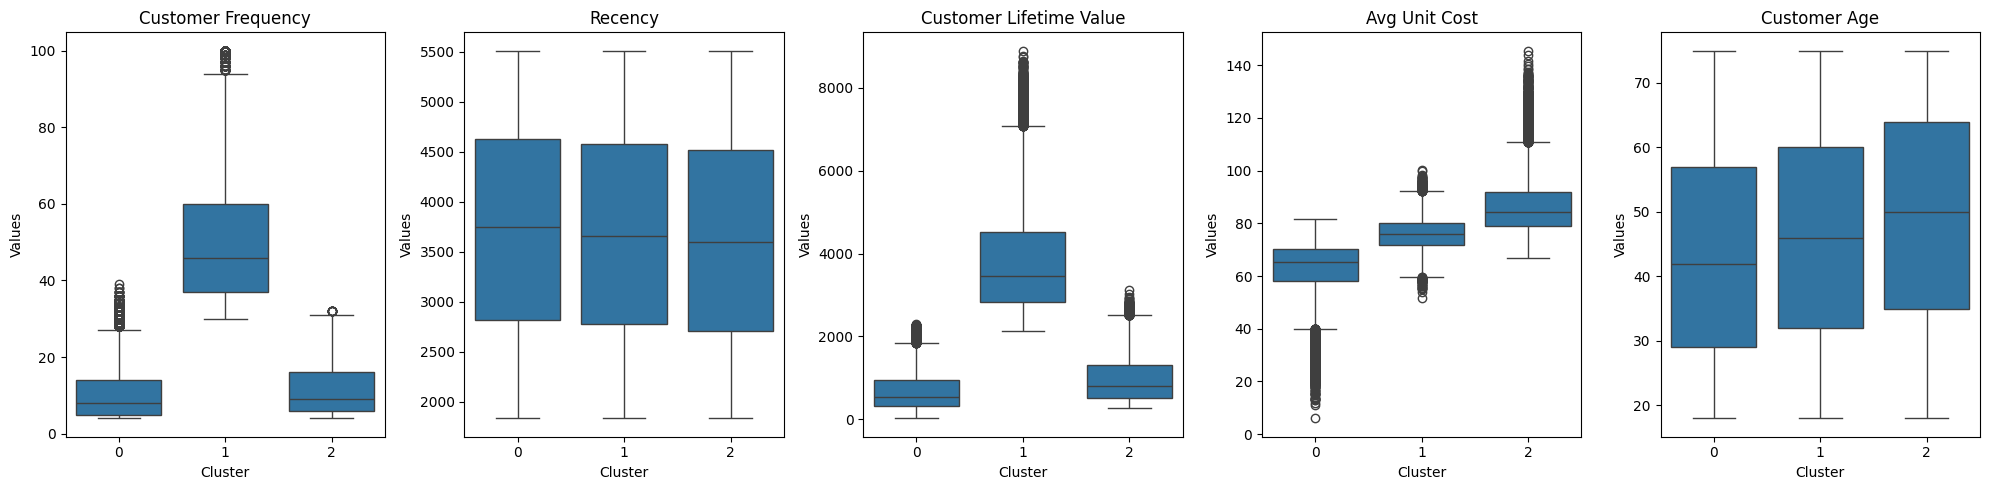

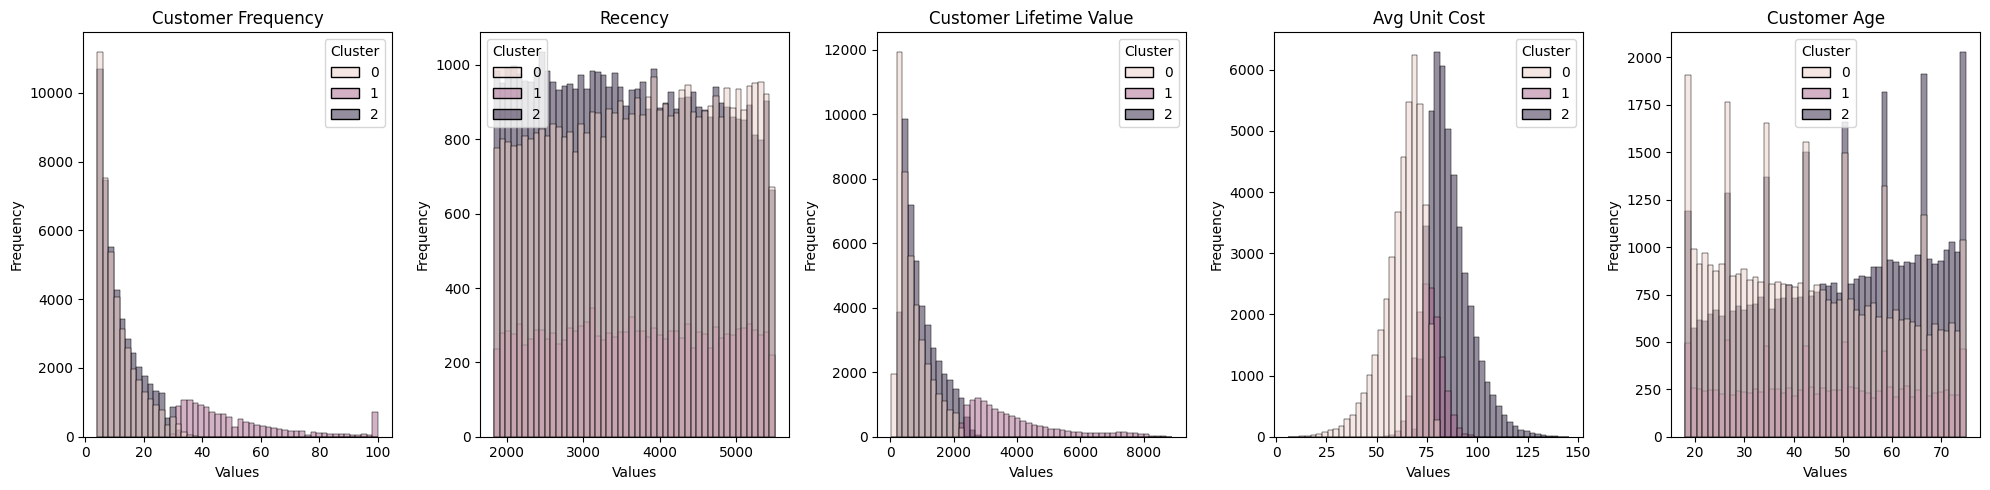

In [62]:
# Visualising data using boxplots and Histograms for each feature
# Exclude 'Customer ID' and 'Cluster' columns
features_to_visualize = df_customer.drop(columns=['Customer ID'])

# Visualising summary statistics using boxplots for each feature by cluster
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns) - 1, figsize=(20, 5))

# Loop through each column and create a boxplot
for i, col in enumerate(features_to_visualize.columns[:-1]):
    sns.boxplot(x='Cluster', y=col, data=features_to_visualize, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

# Visualising distributions of each feature using histograms by cluster
fig, axes = plt.subplots(nrows=1, ncols=len(features_to_visualize.columns) - 1, figsize=(20, 5))

# Loop through each column to create a histogram using seaborn
for i, col in enumerate(features_to_visualize.columns[:-1]):
    sns.histplot(data=features_to_visualize, x=col, hue='Cluster', bins=50, kde=False, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data Visualisation using PCA

In [63]:
# Select columns for clustering
features_for_clustering = df_customer[['Customer Frequency', 'Recency', 'Customer Lifetime Value', 'Avg Unit Cost', 'Customer Age']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the original DataFrame
df_customer['Cluster'] = cluster_labels

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# Create a new DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Add the Customer ID and Cluster columns back to the PCA DataFrame
df_pca['Customer ID'] = df_customer['Customer ID'].values
df_pca['Cluster'] = df_customer['Cluster'].values

# Print the new DataFrame
df_pca

,Principal Component 1,Principal Component 2,Customer ID,Cluster
0,-0.653189,0.271145,189033,0
1,-1.114984,-1.097998,113007,0
2,-0.034197,0.482956,40369,0
3,0.034656,0.621540,2153,0
4,4.042160,0.352317,194850,1
...,...,...,...,...
103099,2.095606,0.574207,8022,1
103100,0.333152,1.085856,61230,2
103101,1.904131,-0.000770,155850,1
103102,6.864668,1.222627,82356,1


In [64]:
# Checking both principal components are normalised appropriately
df_pca.describe().round(2)

,Principal Component 1,Principal Component 2,Customer ID,Cluster
count,103104.00,103104.00,103104.00,103104.00
mean,0.00,0.00,103421.56,1.03
std,1.41,1.00,59551.41,0.93
min,-1.58,-3.93,1.00,0.00
25%,-0.87,-0.72,51801.75,0.00
50%,-0.51,0.01,103586.50,1.00
75%,0.32,0.73,155312.75,2.00
max,7.83,3.79,206208.00,2.00


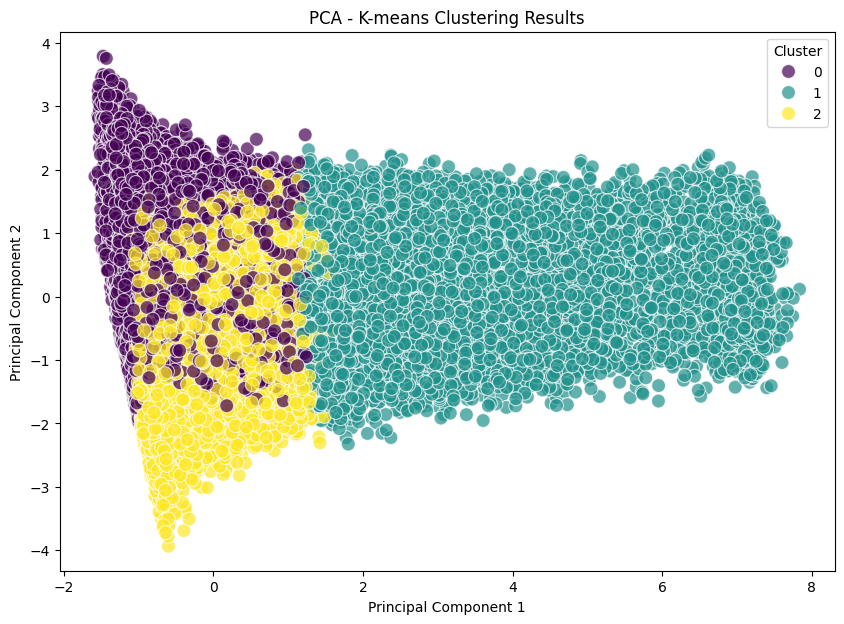

In [65]:
# Plot the scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('PCA - K-means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

PCA is very sensitive to outliers, leading to the rather un-informative graph above. However, removing those outliers is not an option as the analysis would then exclude the customers with the highest lifetime value, and therefore profit to the business. t-SNE is a dimensionality reduction technique which is less sensitive to outliers, and will be used next to visualise the clusters.

# Data Visualisation using t-SNE



In [66]:
# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the original DataFrame
df_customer['Cluster'] = cluster_labels

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(features_scaled)

# Create a new DataFrame with the t-SNE results
df_tsne = pd.DataFrame(data=tsne_components, columns=['TSNE Component 1', 'TSNE Component 2'])

# Add the Customer ID and Cluster columns back to the t-SNE DataFrame
df_tsne['Customer ID'] = df_customer['Customer ID'].values
df_tsne['Cluster'] = df_customer['Cluster'].values

# Print the new DataFrame
df_tsne

,TSNE Component 1,TSNE Component 2,Customer ID,Cluster
0,-38.170185,32.139526,189033,0
1,-81.466599,-76.145622,113007,0
2,-31.990765,43.800983,40369,0
3,-32.163105,45.732269,2153,0
4,102.688980,-16.083195,194850,1
...,...,...,...,...
103099,88.548241,4.623199,8022,1
103100,23.136723,86.640640,61230,2
103101,70.956688,-21.721180,155850,1
103102,127.364380,2.780967,82356,1


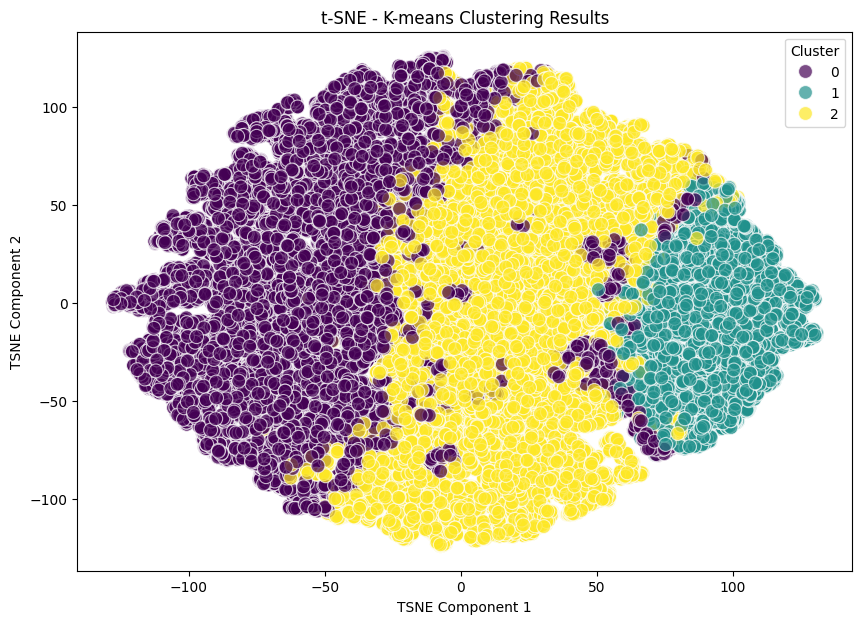

In [67]:
# Plot the t-SNE results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE Component 1', y='TSNE Component 2', hue='Cluster', palette='viridis', data=df_tsne, s=100, alpha=0.7)
plt.title('t-SNE - K-means Clustering Results')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.show()

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].